In [85]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy.random
from scipy import signal
import time
import matplotlib.mlab as mlab
import pycbc
import matplotlib
from scipy.fftpack import fft, fftfreq, rfft
import scipy.signal

In [86]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Shot noise digital filter
def shot_noise_df(fs):
    
    f1 = 1e-5
    f2 = 2e-3
    w1 = f1*2*np.pi
    w2 = f2*2*np.pi

    b = np.array([1, 2*w2, w2**2])
    a = np.array([1, 2*w1, w1**2])

    # Going from analog to digital
    z,p = signal.bilinear(b,a,fs) # THIS ACTUALLY RETURNS b1, a1, NOT z1, p1 as the documentation claims
    b1 = z
    a1 = p
    
    return b1, a1

# TM noise digital filter
def TM_noise_df(fs):
    
    f1 = 1e-5
    f3 = 0.4e-3
    f4 = 1e-2
    w1 = f1*2*np.pi
    w3 = f3*2*np.pi
    w4 = f4*2*np.pi

    z_analog = [-w3,-w4,-w4] # two zeros at w4 in s-space
    p_analog = [-w1,-w1,-w1]
    k = 1
    
    b_analog,a_analog = scipy.signal.zpk2tf(z_analog,p_analog,k)

    # Going from analog to digital
    z,p = signal.bilinear(b_analog,a_analog,fs)
    b = z
    a = p
    
    return b, a

def SC_and_MOSA_df(fs):
    f1     = 1e-5
    f5     = 0.8e-3
    w1 = f1*2*np.pi
    w5 = f5*2*np.pi
    
    b = np.array([1, 2*w5, w5**2])
    a = np.array([1, 2*w1, w1**2])

    # Going from analog to digital
    z,p = signal.bilinear(b,a,fs) # THIS ACTUALLY RETURNS b1, a1, NOT z1, p1 as the documentation claims
    b1 = z
    a1 = p
    
    return b1, a1

In [87]:
# Target noise curves

freq_plot = np.logspace(-5, 0, 1000)
w_plot    = 2*np.pi*freq_plot

shot_psd = ((6e-12)**2)*(1+((2e-3)/freq_plot)**4)
TM_psd   = ((2.4e-15)**2)*((1 + ((0.4e-3)/freq_plot)**2)*(1 + (freq_plot/(8e-3))**4)/(w_plot**4))
SC_psd   = ((5e-9)**2)*(1+((0.8e-3)/freq_plot)**4)
MOSA_psd = ((2e-9)**2)*(1+((0.8e-3)/freq_plot)**4)

In [88]:
freq      = np.logspace(-7, 0, 1000)
f_low_idx = find_nearest(freq, 1e-5)

N  = int(1e6)
fs = 10
dt = 1./fs
T  = dt*N
t  = np.arange(0, T, dt)

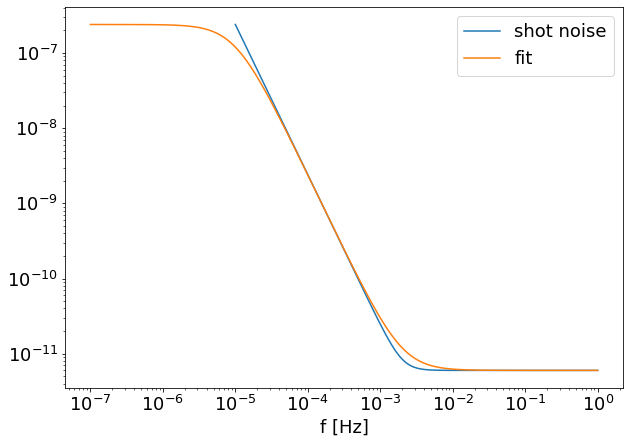

In [96]:
# shot noise

f1     = 1e-5
f2     = 2e-3
m1     = -2
m2     = 0
shot_fit  = (6e-12)**2
shot_fit *= (freq**2 + f1**2)**(m1)
shot_fit *= (freq**2 + f2**2)**(m2-m1)

fig = plt.figure(figsize=(10, 7))
plt.loglog(freq_plot, shot_psd**0.5, label='shot noise')
plt.loglog(freq, shot_fit**0.5, label='fit')
plt.xlabel('f [Hz]')
plt.legend()

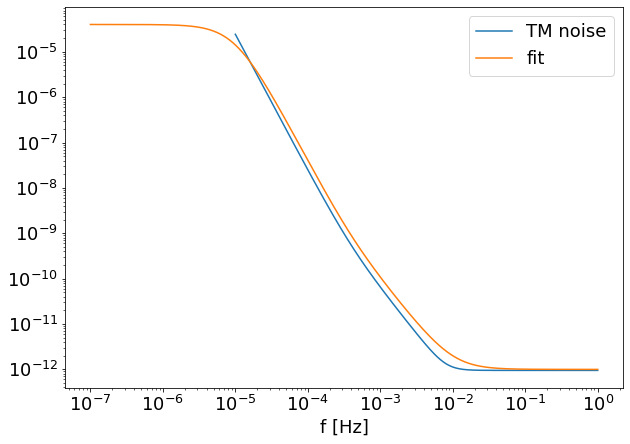

In [97]:
# TM noise

f3 = 0.4e-3
f4 = 1e-2
m3 = -3
m4 = 1
m5 = -(m3+m4)

TM_fit  = (1e-12)**2
TM_fit *= (freq**2 + f1**2)**(m3)
TM_fit *= (freq**2 + f3**2)**(m4)
TM_fit *= (freq**2 + f4**2)**(m5)

fig = plt.figure(figsize=(10, 7))
plt.loglog(freq_plot, TM_psd**0.5, label='TM noise')
plt.loglog(freq, TM_fit**0.5, label='fit')
plt.xlabel('f [Hz]')
plt.legend()

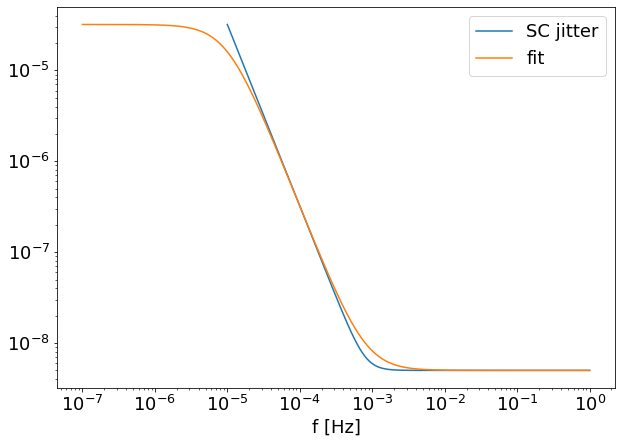

In [98]:
# S/C jitter

f1     = 1e-5
f5     = 0.8e-3
m1     = -2
m2     = 0
SC_fit  = (5e-9)**2
SC_fit *= (freq**2 + f1**2)**(m1)
SC_fit *= (freq**2 + f5**2)**(m2-m1)

fig = plt.figure(figsize=(10, 7))
plt.loglog(freq_plot, SC_psd**0.5, label='SC jitter')
plt.loglog(freq, SC_fit**0.5, label='fit')
plt.xlabel('f [Hz]')
plt.legend()

nan? False


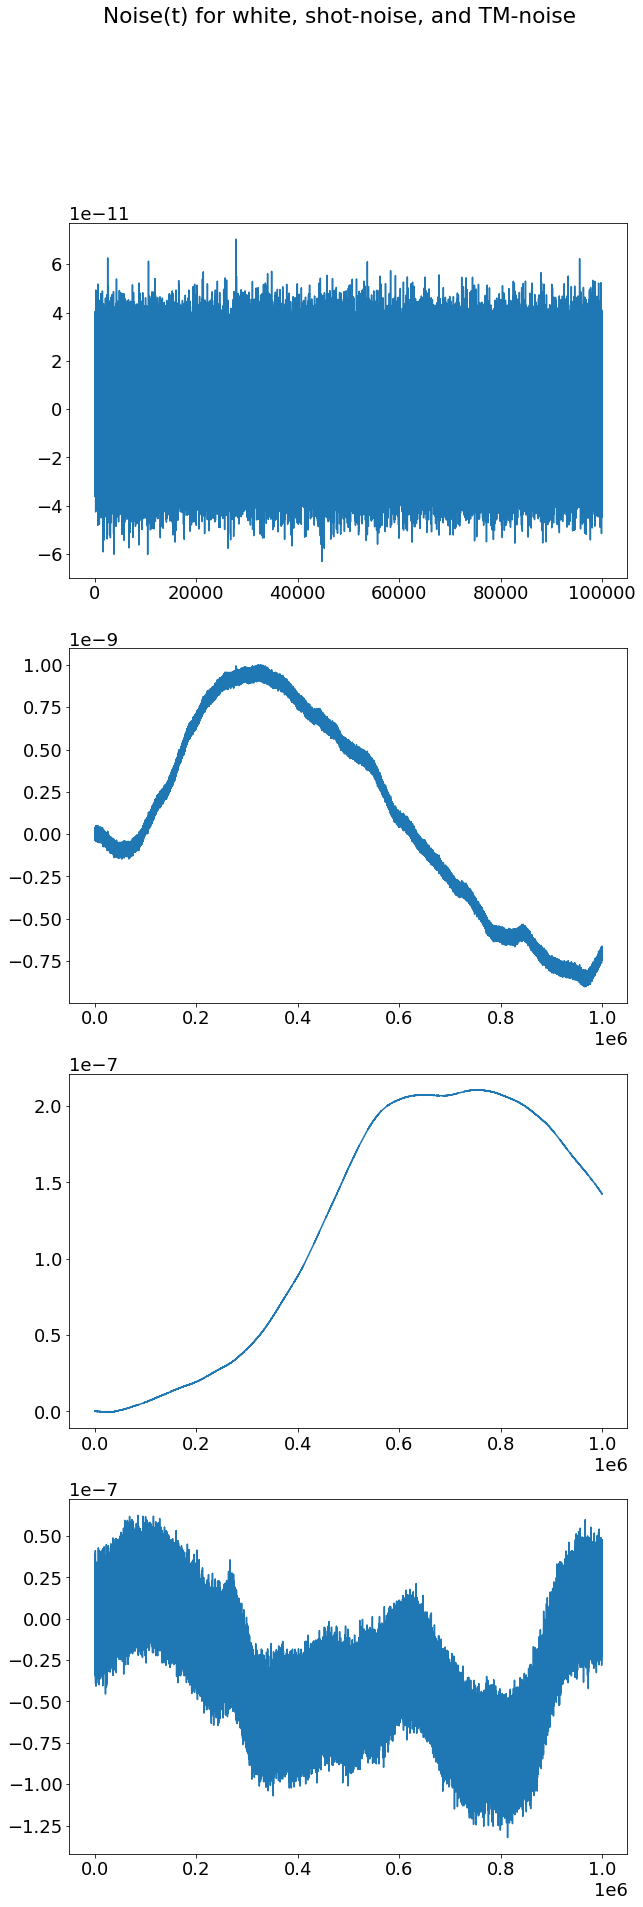

In [104]:
## Generating white noise and coloring

# Shot-noise
mu = 0.
sigma_shot = (6e-12)*((fs/2)**0.5)
n_shot = np.random.normal(mu, sigma_shot, N)

b1, a1 = shot_noise_df(fs)
colored_n_shot = signal.lfilter(b1, a1, n_shot)

# TM-noise
mu = 0.
sigma_TM = (1e-12)*((fs/2)**0.5)
n_TM = np.random.normal(mu, sigma_TM, N)

b2, a2 = TM_noise_df(fs)
colored_n_TM = signal.lfilter(b2, a2, n_TM)

# SC jitter
mu = 0.
sigma_SC  = (5e-9)*((fs/2)**0.5)
SC_jitter = np.random.normal(mu, sigma_SC, N)

b3, a3 = SC_and_MOSA_df(fs)
colored_SC = signal.lfilter(b3, a3, SC_jitter)

# MOSA jitter
mu = 0.
sigma_MOSA  = (5e-9)*((fs/2)**0.5)
MOSA_jitter = np.random.normal(mu, sigma_MOSA, N)

b4, a4 = SC_and_MOSA_df(fs)
colored_MOSA = signal.lfilter(b4, a4, MOSA_jitter)


# Sanity check
print('nan?', np.isnan(colored_n_shot).any())

fig = plt.figure(figsize=(10, 30))
plt.suptitle('Noise(t) for white, shot-noise, and TM-noise')
plt.subplot(411)
plt.plot(t, n_shot)
plt.subplot(412)
plt.plot(colored_n_shot)
plt.subplot(413)
plt.plot(colored_n_TM)
plt.subplot(414)
plt.plot(colored_SC)


## Checking the PSDs to see if they agree with the model

NameError: name 'f_MOSA' is not defined

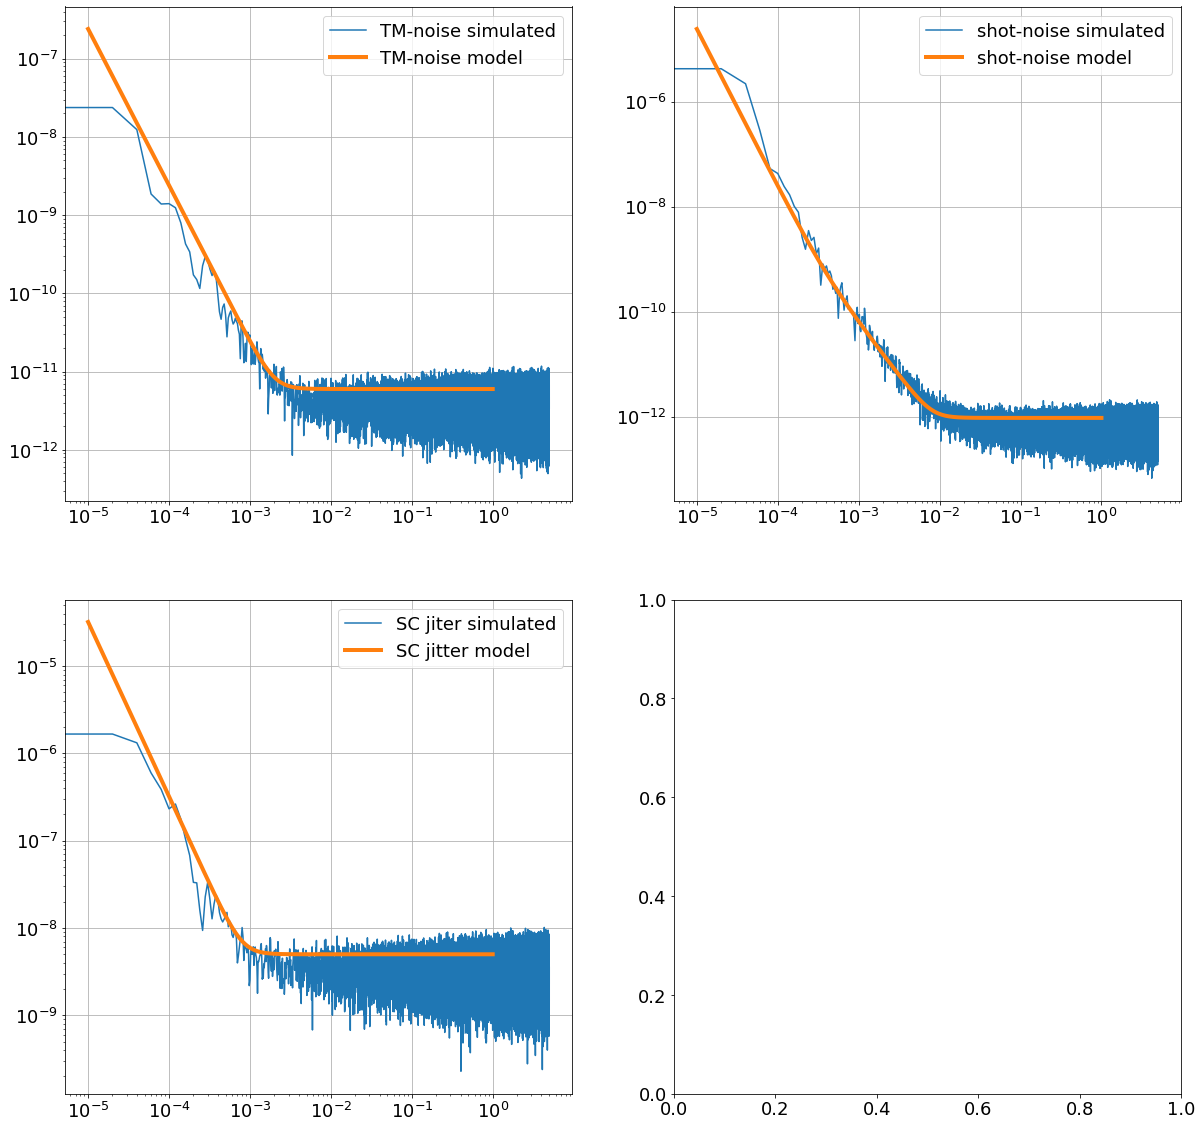

In [105]:
# Estimating PSD with scipy.signal.welch and applying a Hanning filter

n_avg = 2 # changing this number affects resolution, especially at lower frequencies
f_shot, Pxx_shot = signal.welch(colored_n_shot*np.hanning(N), fs, nperseg = N/n_avg, detrend = 'linear', return_onesided=True) 
f_TM, Pxx_TM     = signal.welch(colored_n_TM*np.hanning(N), fs, nperseg = N/n_avg, detrend = 'linear', return_onesided=True)
f_SC, Pxx_SC     = signal.welch(colored_SC*np.hanning(N), fs, nperseg = N/n_avg, detrend = 'linear', return_onesided=True)
f_MOSa, Pxx_MOSa = signal.welch(colored_MOSA*np.hanning(N), fs, nperseg = N/n_avg, detrend = 'linear', return_onesided=True)


fig = plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.loglog(f_shot, Pxx_shot**0.5, label='TM-noise simulated')
plt.loglog(freq_plot, shot_psd**0.5, label='TM-noise model', linewidth=4)
plt.grid()
plt.legend()

plt.subplot(222)
plt.loglog(f_TM, Pxx_TM**0.5, label='shot-noise simulated')
plt.loglog(freq_plot, TM_psd**0.5, label='shot-noise model', linewidth=4)
plt.grid()
plt.legend()

plt.subplot(223)
plt.loglog(f_SC, Pxx_SC**0.5, label='SC jiter simulated')
plt.loglog(freq_plot, SC_psd**0.5, label='SC jitter model', linewidth=4)
plt.grid()
plt.legend()

plt.subplot(224)
plt.loglog(f_MOSA, Pxx_MOSA**0.5, label='MOSA jiter simulated')
plt.loglog(freq_plot, MOSA_psd**0.5, label='MOSA jitter model', linewidth=4)
plt.grid()
plt.legend()

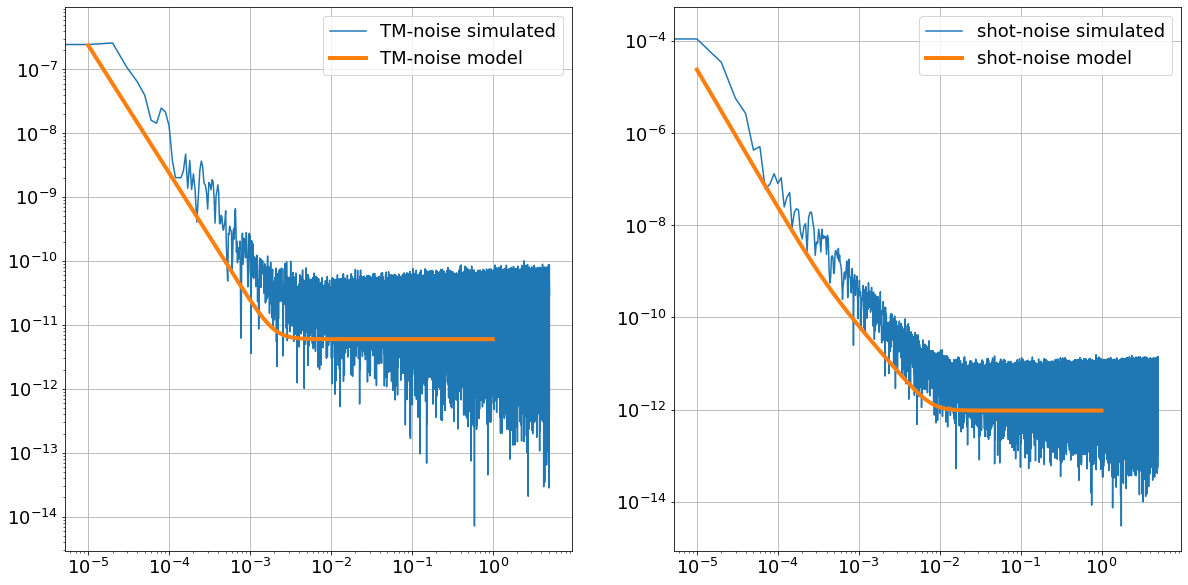

In [102]:
# Estimating PSD as FFT/T^2

fft_shot = fft(colored_n_shot*np.hanning(N))
freqs1   = fftfreq(N, dt)[:N//2]
fft_TM   = fft(colored_n_TM*np.hanning(N))
freqs2   = fftfreq(N, dt)[:N//2]

fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.loglog(freqs1, np.abs(fft_shot[:N//2])*(T**(-.5)), label='TM-noise simulated')
plt.loglog(freq_plot, shot_psd**0.5, label='TM-noise model', linewidth=4)
plt.grid()
plt.legend()

plt.subplot(122)
plt.loglog(freqs2, np.abs(fft_TM[:N//2])*(T**(-.5)), label='shot-noise simulated')
plt.loglog(freq_plot, TM_psd**0.5, label='shot-noise model', linewidth=4)
plt.grid()
plt.legend()



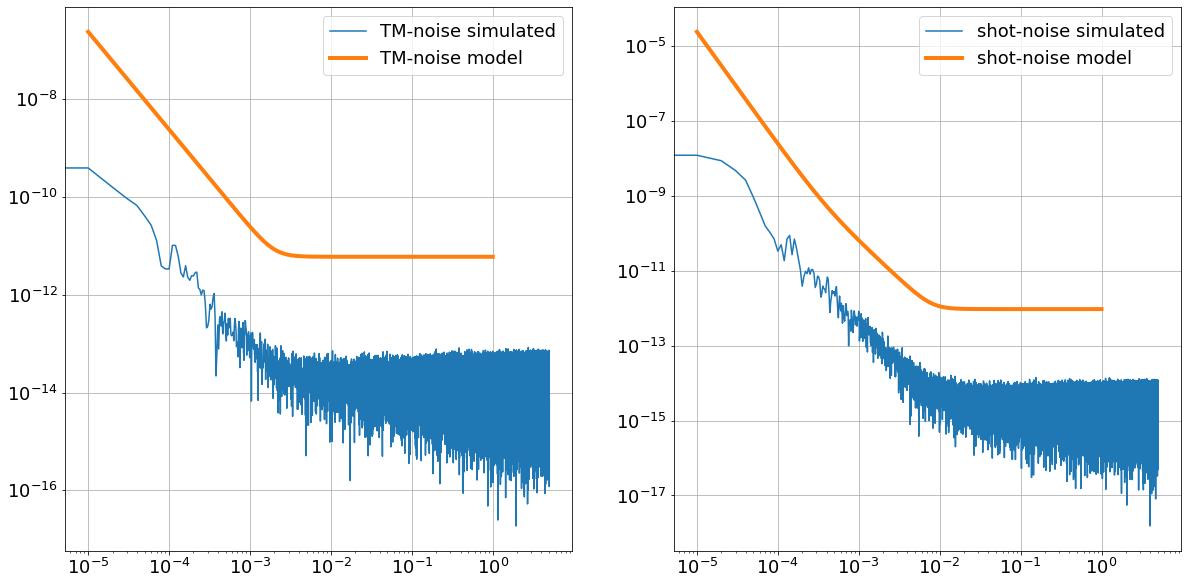

In [70]:
# signal periodogram

f_shot, Pxx_shot = signal.periodogram(colored_n_shot, fs, window="hanning", return_onesided=True, scaling='spectrum')
f_TM, Pxx_TM     = signal.periodogram(colored_n_TM, fs, window="hanning", return_onesided=True, scaling='spectrum') 


fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.loglog(f_shot, Pxx_shot**0.5, label='TM-noise simulated')
plt.loglog(freq_plot, shot_psd**0.5, label='TM-noise model', linewidth=4)
plt.grid()
plt.legend()

plt.subplot(122)
plt.loglog(f_TM, Pxx_TM**0.5, label='shot-noise simulated')
plt.loglog(freq_plot, TM_psd**0.5, label='shot-noise model', linewidth=4)
plt.grid()
plt.legend()